In [1]:
import xarray as xr
import numpy as np

# Load Data

In [2]:
glac1d_sim_ds = xr.open_dataset("../../data/simulations/ld_glac1d.nc")
glac1d_obs_ds = xr.open_dataset("../../data/reconstructions/glac1d_laea_5km_eurasia.nc")

ice6g_sim_ds = xr.open_dataset("../../data/simulations/ld_ice6g.nc")
ice6g_obs_ds = xr.open_dataset("../../data/reconstructions/ice6g_laea_5km_eurasia.nc")

times = [-22000, -20000, -18000, -16000]
x, y = glac1d_sim_ds.x.values, glac1d_sim_ds.y.values
dA = np.abs(x[1] - x[0]) * np.abs(y[1] - y[0])

In [3]:
obs_da = xr.concat(
    [
        glac1d_obs_ds.ice_thickness.sel(time=times),
        ice6g_obs_ds.ice_thickness.sel(time=times)
    ],
    dim=xr.DataArray(
        ["glac1d", "ice6g"], 
        dims="model"
    )
)

In [4]:
sim_da = xr.concat(
    [
        glac1d_sim_ds.ice_thickness.sel(time=times),
        ice6g_sim_ds.ice_thickness.sel(time=times)
    ],
    dim=xr.DataArray(
        ["glac1d", "ice6g"], 
        dims="model"
    )
).transpose("ensemble_index", "model", "time", "y", "x")

# Generate Masks

In [5]:
shape = glac1d_sim_ds.ice_thickness[0,0].shape
# barants-kara sea
mask_bks = np.zeros(shape)
mask_bks[588:, :] = 1

# fennoscandia
mask_f = np.zeros(shape)
mask_f[:588, 294:] = 1

# british-irish
mask_bi = np.zeros(shape)
mask_bi[:588, :294] = 1

metric_masks_da = xr.DataArray(
    [mask_bi, mask_bks, mask_f],
    coords={
        "metric":["bi", "bks", "f"],
        "y":y,
        "x":x
    }
)
metric_masks_da = metric_masks_da.rename("metric_mask")


data_mask_da = (sim_da.sel(ensemble_index=0) > 0).astype(int) * (obs_da > 0).astype(int)
data_mask_da = data_mask_da.rename("data_mask")
mask_ds = xr.merge([metric_masks_da, data_mask_da])

In [6]:
mask_ds.to_netcdf("masks.nc")

# Calculate Metrics

In [7]:
metric_obs_da = dA*(obs_da * mask_ds.metric_mask).sum(dim=["x", "y"])
metric_sim_da = dA*(sim_da * mask_ds.metric_mask).sum(dim=["x", "y"])

# Calculate Variance and Bias

In [8]:
se_da = ((sim_da - obs_da)**2)*mask_ds.data_mask

In [9]:
rmse = np.zeros(
    (len(se_da.ensemble_index), len(se_da.model), len(se_da.time))
)
for m_idx, model in enumerate(se_da.model.values):
    for t_idx, time in enumerate(se_da.time.values):
        rmse[:, m_idx, t_idx] = np.sqrt(
            se_da.sel(model=model, time=time).values[
                :,
                mask_ds.data_mask.sel(model=model, time=time).values.astype(bool)
            ].mean(axis=1)
        )
rmse_da = xr.DataArray(
    rmse,
    coords={
        "ensemble_index": se_da.ensemble_index, 
        "model": se_da.model, 
        "time": se_da.time, 
    }
)

In [10]:
# look at the residuals of the best 20 members
rmse_order_da = np.argsort(rmse_da, axis=0).drop("ensemble_index")
sim_low_rmse_da = sim_da[rmse_order_da[:20,:,:]]

In [21]:
# bias fields
sim_bias_da = (sim_low_rmse_da- obs_da).mean(dim="ensemble_index")
sim_var_da = (sim_low_rmse_da - obs_da).var(dim="ensemble_index")

In [22]:
# sum the bias fields, in the same way as you would thickness field
metric_sim_bias_da = dA*(sim_bias_da * mask_ds.metric_mask).sum(dim=["x", "y"])
metric_sim_var_da = dA*(sim_var_da * mask_ds.metric_mask).sum(dim=["x", "y"])

In [23]:
metric_obs_var_da = metric_obs_da.var(dim="model")

# Debias Simulations and Metrics

In [24]:
metric_sim_debiased_da = metric_sim_da - metric_sim_bias_da

In [25]:
sim_debiased_da = sim_da - sim_bias_da

In [26]:
ld_metric_ds = xr.merge(
    [
        rmse_da.rename("rmse"),
        sim_bias_da.rename("sim_bias"),
        sim_var_da.rename("sim_var"),
        sim_debiased_da.rename("sim_debiased"),
        metric_sim_da.rename("metric_sim"),
        metric_obs_da.rename("metric_obs"),
        metric_sim_bias_da.rename("metric_sim_bias"),
        metric_sim_var_da.rename("metric_sim_var"),
        metric_obs_var_da.rename("metric_obs_var"),
        metric_sim_debiased_da.rename("metric_sim_debiased"),
    ]
).transpose("ensemble_index", "metric", "model", "time", "y", "x")
ld_metric_ds.to_netcdf("ld_metrics.nc")

# Calculate Implausibility

In [2]:
ld_metric_ds = xr.open_dataset("ld_metrics.nc")

In [3]:
fudge_factor_da = xr.DataArray(
    [1.0, 1.2, 1.4, 1.6],
    coords={"fudge_factor": [1.0, 1.2, 1.4, 1.6]}
)
imp_numerator = (ld_metric_ds.metric_sim_debiased - ld_metric_ds.metric_obs)**2
imp_denominator = ((ld_metric_ds.metric_sim_var + ld_metric_ds.metric_obs_var)*fudge_factor_da)
imp = np.sqrt(imp_numerator/imp_denominator)

mean_imp = imp.mean(dim=["model", "time", "metric"])
nroy = mean_imp<=3

In [85]:
implausibility_ds = xr.merge(
    [
        imp.rename("implausibility"),
        mean_imp.rename("implausibility_mean"),
    ]
)
implausibility_ds.to_netcdf("ld_implausibility.nc")

In [50]:
pre_nroy_metrics = ld_metric_ds.metric_sim_debiased
post_nroy_metrics = ld_metric_ds.metric_sim_debiased[nroy.sel(fudge_factor=1.2).values]

In [40]:
from icepy import volume_to_sle

In [54]:
volume_to_sle(pre_nroy_metrics.sum(dim="metric").max())

<xarray.DataArray 'metric_sim_debiased' ()>
array(29.65017609)
Coordinates:
    spatial_ref  int64 ...

In [55]:
volume_to_sle(post_nroy_metrics.sum(dim="metric").max())

<xarray.DataArray 'metric_sim_debiased' ()>
array(21.14302524)
Coordinates:
    spatial_ref  int64 ...

In [47]:
volume_to_sle(post_nroy_metrics.sum(dim="metric").min())

<xarray.DataArray 'metric_sim_debiased' ()>
array(10.27249966)
Coordinates:
    spatial_ref  int64 ...

In [36]:
(100*(post_nroy_metrics - pre_nroy_metrics)/pre_nroy_metrics)#.sel(time=-16000).sel(metric="bks")

<xarray.DataArray 'metric_sim_debiased' (metric: 3, model: 2, time: 4)>
array([[[ -5.74085498,  -6.4609191 ,  -5.7207822 ,  -7.17822368],
        [-10.85942141,  -9.54939752,  -7.06810591,  -8.69944279]],

       [[ -9.46381581,  -9.63217734,  -7.93147002,  -4.64332007],
        [ -8.16655714, -10.15330762, -11.47304954, -10.59466045]],

       [[-10.35865915, -11.39505361, -12.67440101, -11.76286888],
        [-13.12961524, -14.26326231, -16.00734539, -14.25257452]]])
Coordinates:
  * model        (model) object 'glac1d' 'ice6g'
  * time         (time) int64 -22000 -20000 -18000 -16000
    spatial_ref  int64 0
  * metric       (metric) object 'bi' 'bks' 'f'

In [13]:
nroy.sel(fudge_factor=1.2).sum()/200

<xarray.DataArray ()>
array(0.42)
Coordinates:
    spatial_ref   int64 0
    fudge_factor  float64 1.2

In [11]:
mean_imp.sel(fudge_factor=1.2).std()

<xarray.DataArray ()>
array(2.41160806)
Coordinates:
    spatial_ref   int64 0
    fudge_factor  float64 1.2

In [17]:
mean_imp.sel(fudge_factor=1.2)[nroy.sel(fudge_factor=1.2).values].mean()

<xarray.DataArray ()>
array(2.12181931)
Coordinates:
    spatial_ref   int64 0
    fudge_factor  float64 1.2

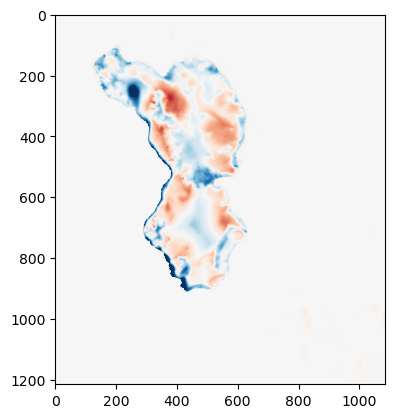

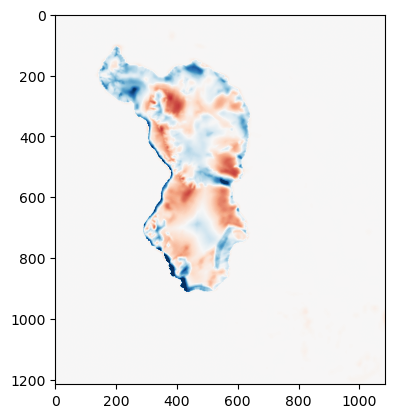

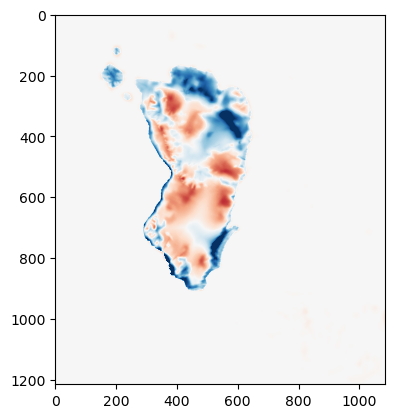

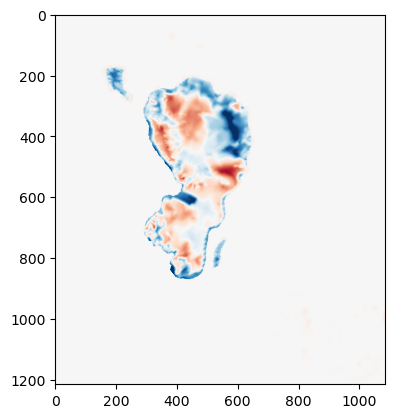

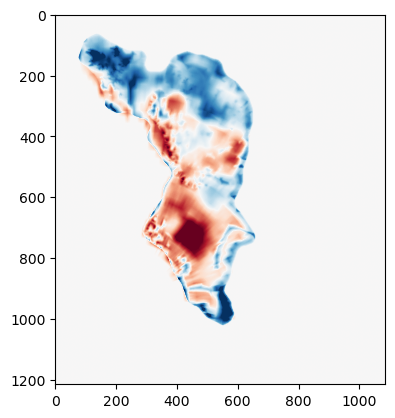

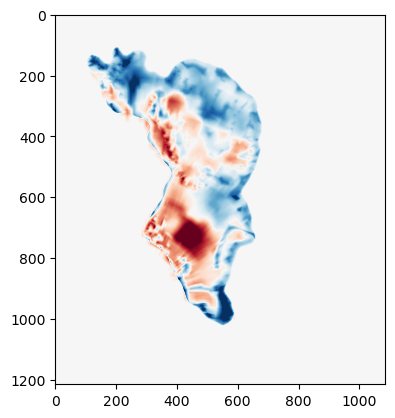

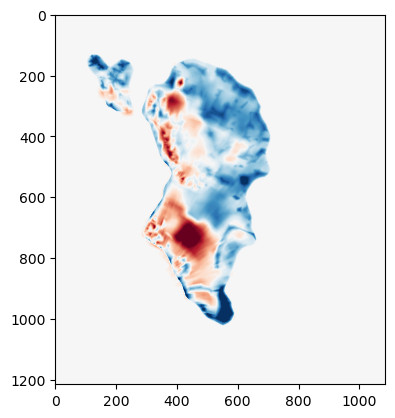

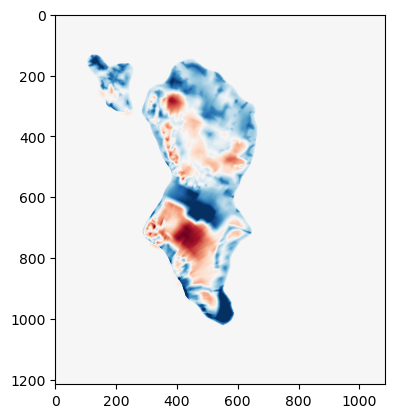

In [61]:
import matplotlib.pyplot as plt
for model in ld_metric_ds.model:
    for time in ld_metric_ds.time:
        plt.imshow(ld_metric_ds.sim_bias.sel(model=model, time=time).values, vmin=-1000, vmax=1000, cmap="RdBu")
        plt.show()